In [6]:
import pandas as pd
import glob
import os
import os
import pickle
import glob
import pandas as pd
from collections import Counter

def get_top_n_words_from_csv(csv_path, n=2000):
    df = pd.read_csv(csv_path)
    return set(df.sort_values("frequency", ascending=False).head(n)["word"])

def get_global_overlap_words(csv_dir, n=2000):
    """
    Find the overlap words among the top n words of all subreddits in csv_dir.
    """
    csv_files = glob.glob(os.path.join(csv_dir, "*_word_freq.csv"))
    top_words_list = [get_top_n_words_from_csv(f, n) for f in csv_files]
    if not top_words_list:
        print("No CSV files found.")
        return set()
    overlap = set.intersection(*top_words_list)
    print(f"Top {n} overlap words among all subreddits: {len(overlap)}")
    return overlap

overlap = get_global_overlap_words("../../output/word_frequency/word_freq_csv", n=8000)
print(overlap)

def load_google_vocab(filepath, top_n=5000):
    with open(filepath, "r", encoding="utf-8") as f:
        words = [line.strip() for line in f.readlines()]
    return set(words[:top_n])

google_vocab = load_google_vocab("../../output/word_frequency/word_freq_csv/google-10000-english-usa.txt", top_n=5000)
overlap_with_google = overlap & google_vocab
print(f"Overlap with Google top 3k: {len(overlap_with_google)}")
print(overlap_with_google)

Top 8000 overlap words among all subreddits: 3687
{'brave', 'brown', 'scam', 'functional', 'treat', 'yellow', 'username', 'crew', 'rating', 'last', 'fool', 'neck', 'pocket', 'log', 'hell', 'rip', 'instance', 'flaw', 'achieve', 'property', 'ban', 'love', 'course', 'technology', 'one', 'genuine', 'predict', 'gender', 'tin', 'symptom', 'stage', 'position', 'navigate', 'failure', 'crisis', 'national', 'power', 'senior', 'semi', 'forget', 'circle', 'trash', 'hello', 'instrument', 'diet', 'ask', 'brush', 'necessity', 'tight', 'nope', 'strand', 'tempt', 'root', 'chef', 'fifteen', 'construction', 'tree', 'parallel', 'hey', 'cycle', 'approach', 'vaguely', 'pad', 'iron', 'shortly', 'proper', 'con', 'adventure', 'wrist', 'curve', 'weapon', 'coat', 'pen', 'presence', 'forgotten', 'survive', 'echo', 'scare', 'adapt', 'development', 'advantage', 'wreck', 'storage', 'blanket', 'seal', 'fan', 'wont', 'exceptional', 'clue', 'weigh', 'monkey', 'environmental', 'cousin', 'warrant', 'subreddit', 'contain'

In [2]:
import gensim

input_dir = "models/chunk_3"
democrats_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2021_2024.model")

In [ ]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

model_list = [
    ("democrats_before_2016", democrats_before_2016),
    ("democrats_2017_2020", democrats_2017_2020),
    ("democrats_2021_2024", democrats_2021_2024),
    ("republican_before_2016", republican_before_2016),
    ("republican_2017_2020", republican_2017_2020),
    ("republican_2021_2024", republican_2021_2024),
]

all_model_vocab = set.intersection(*(set(model.wv.key_to_index.keys()) for _, model in model_list))

all_models_google_overlap = all_model_vocab & overlap_with_google

all_models_stopwords_overlap = all_model_vocab & stop_words

all_models_union = all_models_google_overlap | all_models_stopwords_overlap

print(f"All models & google vocab overlap: {len(all_models_google_overlap)}")
print(f"All models & stopwords overlap: {len(all_models_stopwords_overlap)}")
print(f"Union: {len(all_models_union)}")
print(sorted(all_models_union))

All models & google vocab overlap: 993
All models & stopwords overlap: 103
Union: 1096
['ability', 'able', 'about', 'above', 'accept', 'accepted', 'access', 'account', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'add', 'addition', 'additional', 'address', 'adult', 'advance', 'advertising', 'advice', 'after', 'again', 'against', 'age', 'agent', 'ago', 'agree', 'aid', 'ain', 'air', 'all', 'allow', 'almost', 'along', 'already', 'also', 'alternative', 'although', 'always', 'amazon', 'america', 'american', 'among', 'amount', 'and', 'animal', 'another', 'answer', 'anti', 'any', 'anyone', 'anything', 'appear', 'apple', 'apply', 'approach', 'appropriate', 'area', 'aren', 'army', 'around', 'art', 'article', 'asian', 'ask', 'attention', 'australia', 'australian', 'author', 'authority', 'auto', 'available', 'average', 'award', 'away', 'baby', 'back', 'background', 'bad', 'bag', 'balance', 'ball', 'band', 'bank', 'bar', 'base', 'basic', 'basis', 'bay', 'beach', 'beautifu

In [6]:
import numpy as np
import pandas as pd
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, anchor_words, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    
    anchor = [w for w in anchor_words if w in vocab1 and w in vocab2]
    print(f"{time_period}: Anchor words between {subreddit1_name} and {subreddit2_name}: {len(anchor)} words")
    if len(anchor) == 0:
        print("No anchor words found in both models.")
        return None
    
    anchor_vecs1 = np.array([model1.wv[w] for w in anchor])
    anchor_vecs2 = np.array([model2.wv[w] for w in anchor])
    anchor_vecs1 = anchor_vecs1 - anchor_vecs1.mean(axis=0, keepdims=True)
    anchor_vecs2 = anchor_vecs2 - anchor_vecs2.mean(axis=0, keepdims=True)
    anchor_vecs1 = anchor_vecs1 / np.linalg.norm(anchor_vecs1, axis=1, keepdims=True)
    anchor_vecs2 = anchor_vecs2 / np.linalg.norm(anchor_vecs2, axis=1, keepdims=True)
    m = anchor_vecs1.T @ anchor_vecs2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    common_vocab = list(vocab1.intersection(vocab2))
    print(f"{time_period}: Anchor words: {len(anchor)}, Common vocab: {len(common_vocab)}")
    vecs1 = np.array([model1.wv[w] for w in common_vocab])
    vecs2 = np.array([model2.wv[w] for w in common_vocab])
    vecs1 = vecs1 - vecs1.mean(axis=0, keepdims=True)
    vecs2 = vecs2 - vecs2.mean(axis=0, keepdims=True)
    vecs1 = vecs1 / np.linalg.norm(vecs1, axis=1, keepdims=True)
    vecs2 = vecs2 / np.linalg.norm(vecs2, axis=1, keepdims=True)
    vecs2_aligned = vecs2 @ rotation

    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vecs1[i].reshape(1, -1), vecs2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))

    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    df = df.sort_values('similarity')

    if output_file:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)

    return df

# Define input directory where models are stored
input_dir = "models/chunk_3"
# Define output directory
output_dir = "output/chunk_3"
os.makedirs(output_dir, exist_ok=True)

# Define all pairs and periods to compare
subreddit_pairs = [
    ("republican", "democrats")
]
periods = ["before_2016", "2017_2020", "2021_2024"]

# Load all models into a dict for easy access
model_names = ["democrats", "republican"]
models = {}
for name in model_names:
    models[name] = {}
    for period in periods:
        models[name][period] = gensim.models.Word2Vec.load(f"{input_dir}/{name}_{period}.model")

# Compare all pairs for all periods and save results
for sub1, sub2 in subreddit_pairs:
    for period in periods:
        output_file = f"{output_dir}/{sub1}_{sub2}_{period}.csv"
        compare_subreddit_embeddings_by_period(
            models[sub1][period],
            models[sub2][period],
            sub1,
            sub2,
            period,
            anchor_words=all_models_union,
            output_file=output_file
        )

print(f"Results saved to {output_dir}")
print("\nAnalysis complete.")

before_2016: Anchor words between republican and democrats: 1096 words
before_2016: Anchor words: 1096, Common vocab: 10762
2017_2020: Anchor words between republican and democrats: 1096 words
2017_2020: Anchor words: 1096, Common vocab: 15356
2021_2024: Anchor words between republican and democrats: 1096 words
2021_2024: Anchor words: 1096, Common vocab: 18617
Results saved to output/chunk_3

Analysis complete.


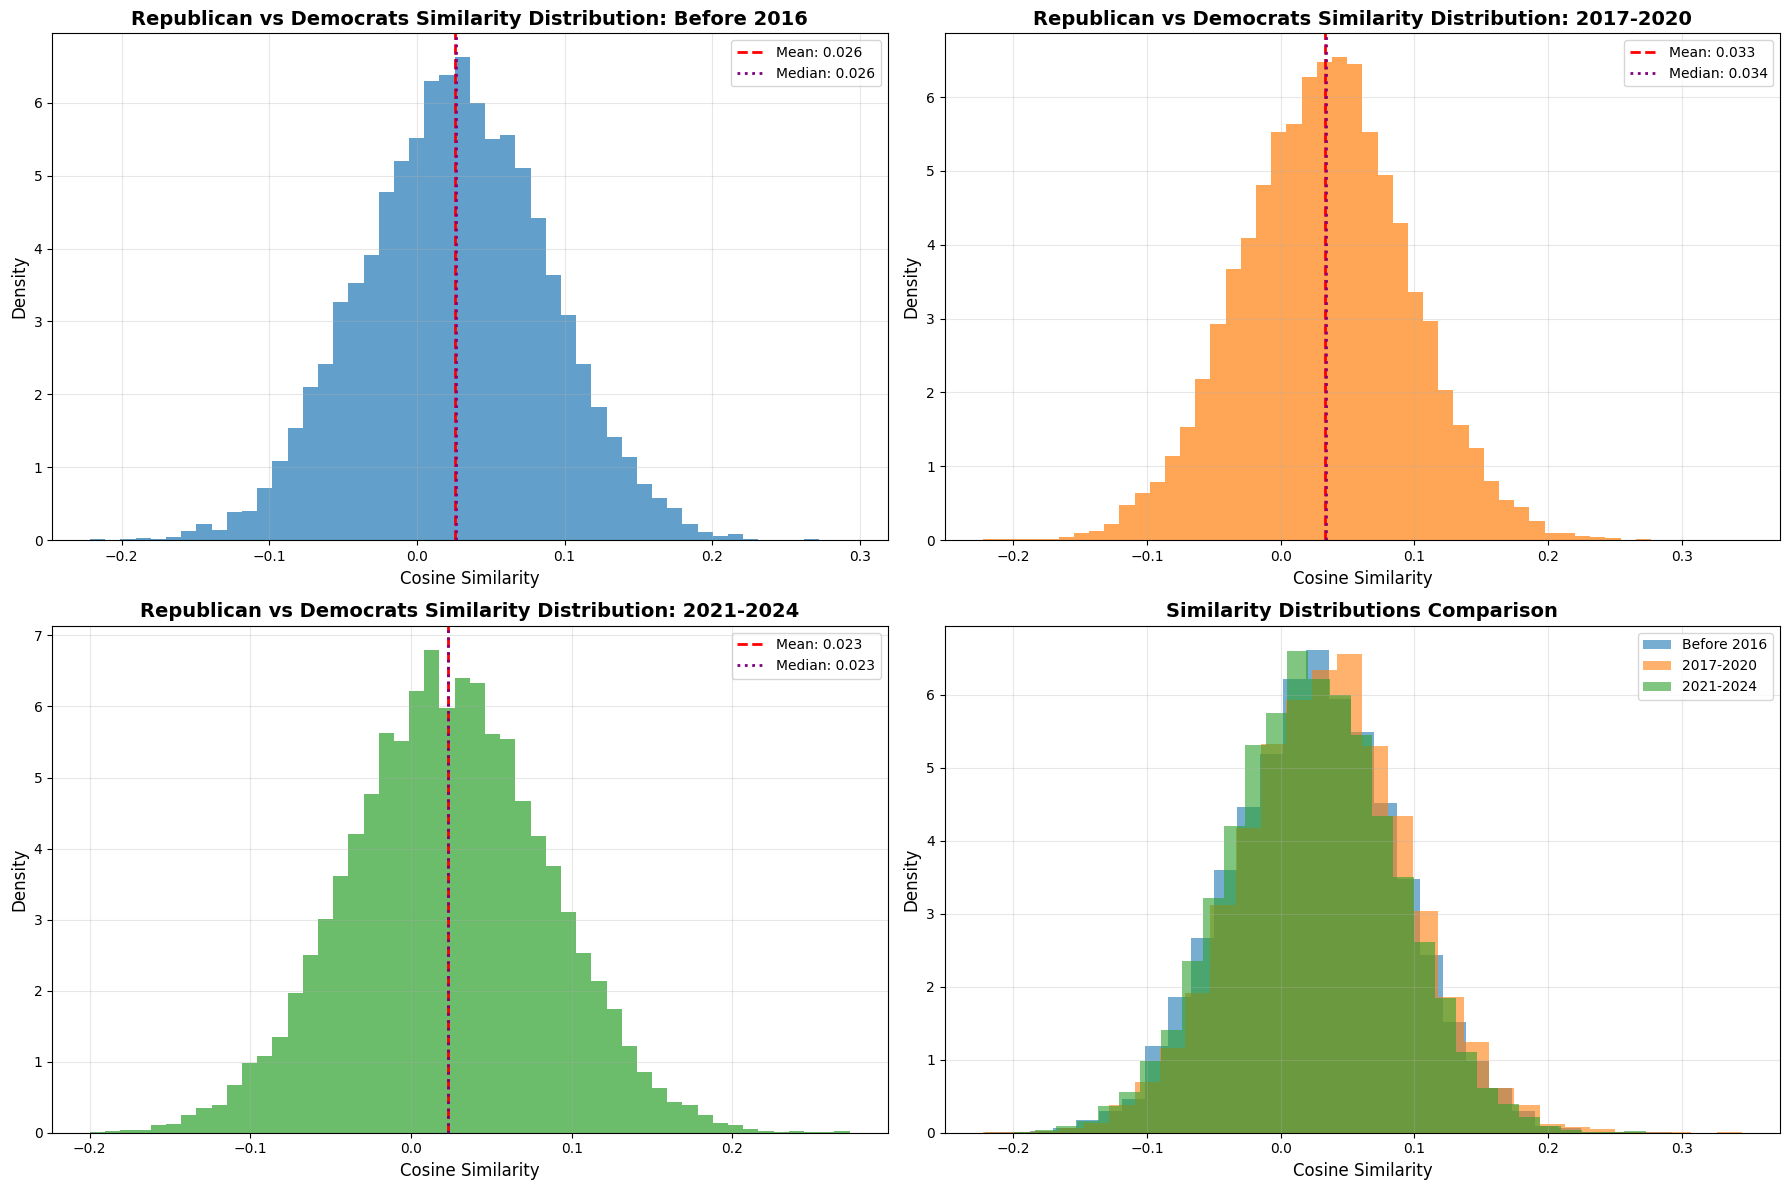

In [7]:
def analyze_similarity_distributions(output_dir, df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()


input_dir = "output/chunk_3"
# Run the analysis
subreddit_pairs = [
    ("republican", "democrats")
]
periods = ["before_2016", "2017_2020", "2021_2024"]

for sub1, sub2 in subreddit_pairs:
    dfs = []
    for period in periods:
        csv_path = f"{input_dir}/{sub1}_{sub2}_{period}.csv"
        dfs.append(pd.read_csv(csv_path))
    analyze_similarity_distributions(
        input_dir,
        dfs[0], dfs[1], dfs[2],
        sub1.capitalize(), sub2.capitalize()
    )

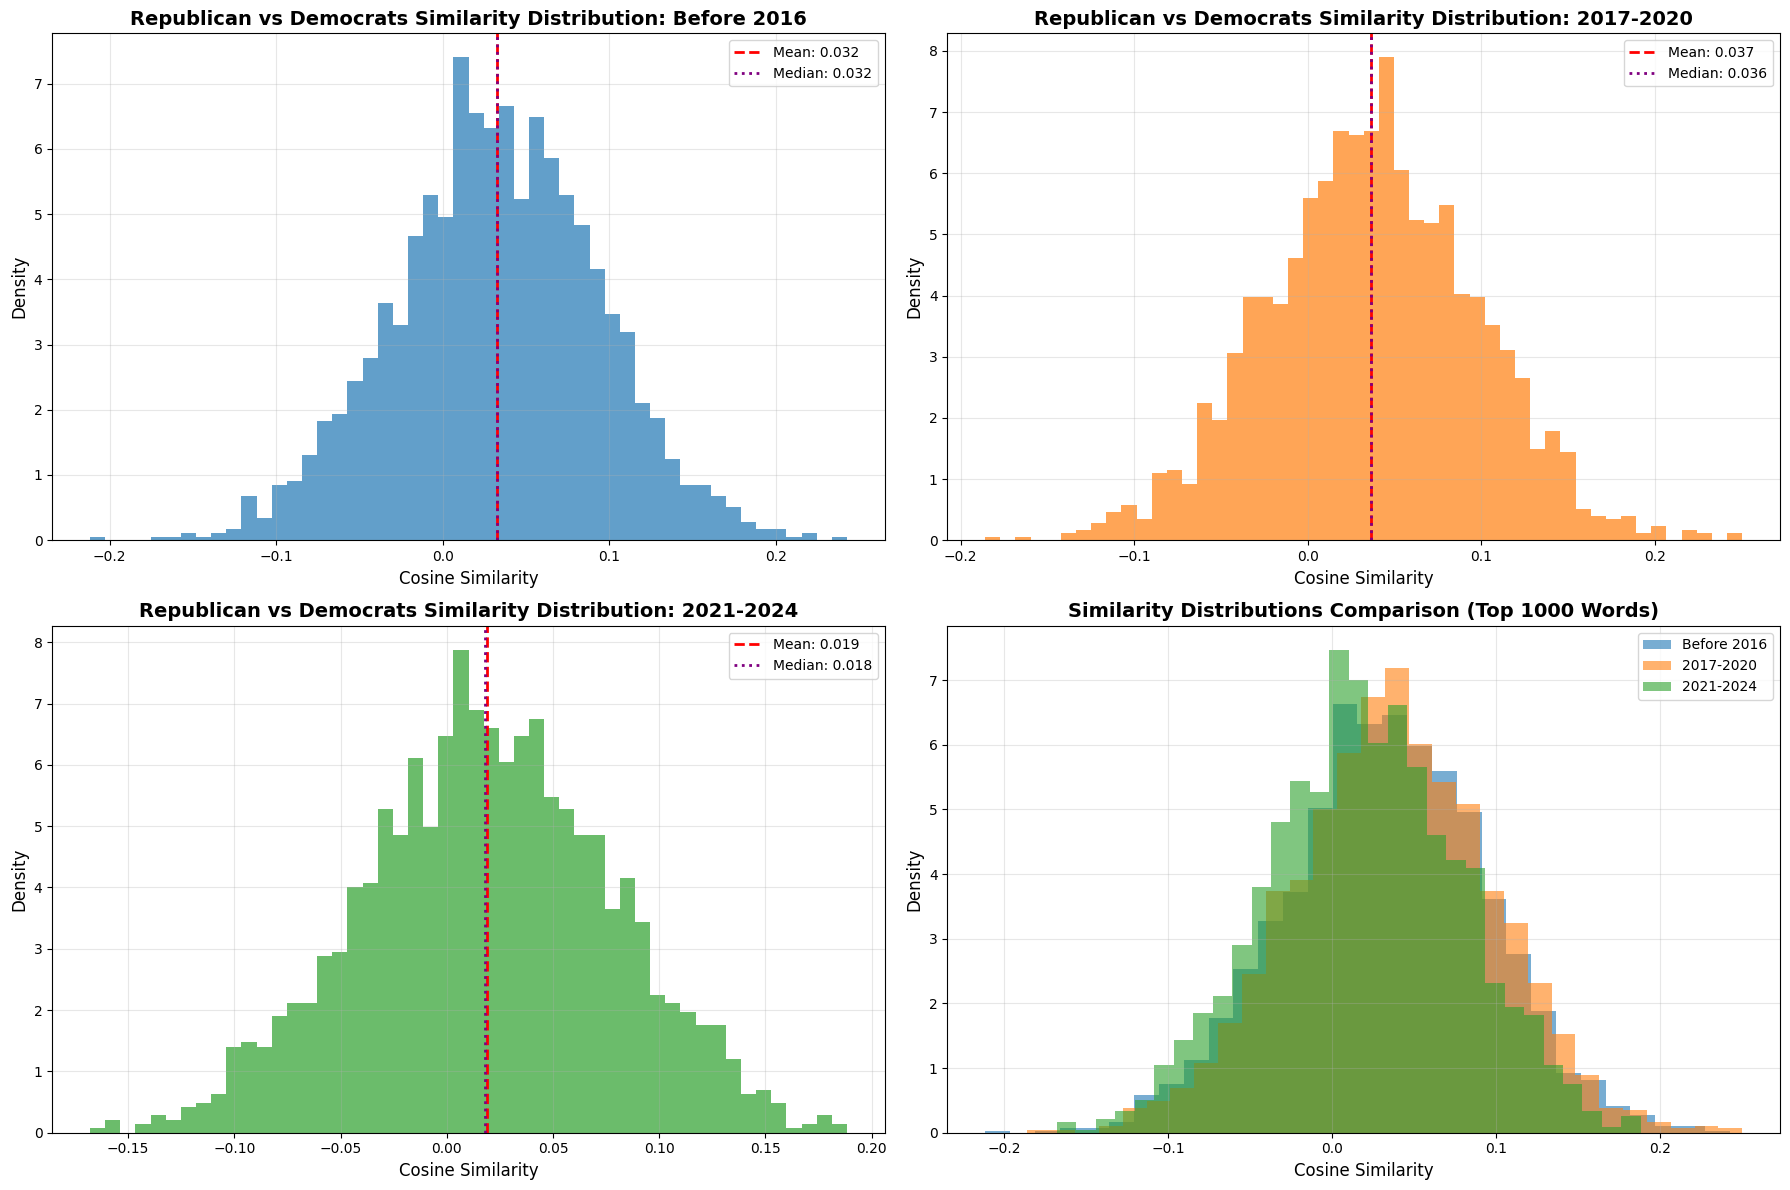

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load top 1000 words from TF-IDF diff
tfidf_diff_path = "output/political_words_tfidf_diff.csv"
top_words = pd.read_csv(tfidf_diff_path).head(2000)["word"].tolist()

# Load similarity CSVs for each period
input_dir = "output/chunk_3"
sub1, sub2 = "republican", "democrats"
periods = ["before_2016", "2017_2020", "2021_2024"]
dfs = []
for period in periods:
    csv_path = f"{input_dir}/{sub1}_{sub2}_{period}.csv"
    df = pd.read_csv(csv_path)
    # Filter only top_words
    df = df[df["word"].isin(top_words)]
    dfs.append(df)

period_names = ['Before 2016', '2017-2020', '2021-2024']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(18, 12))

# Individual distributions with mean/median
for i, (df, period, color) in enumerate(zip(dfs, period_names, colors)):
    plt.subplot(2, 2, i+1)
    plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, color=color)
    mean_sim = df['similarity'].mean()
    median_sim = df['similarity'].median()
    plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.3f}')
    plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2, label=f'Median: {median_sim:.3f}')
    plt.title(f'{sub1.capitalize()} vs {sub2.capitalize()} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

# Combined comparison plot
plt.subplot(2, 2, 4)
for i, (df, period, color) in enumerate(zip(dfs, period_names, colors)):
    plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, label=period, color=color)
plt.title('Similarity Distributions Comparison (Top 1000 Words)', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()